                                                        6ta Escuela Uniandina de Detectores de Partículas-2023.
                                                                    Universidad de los Andes
                                                                        Depto de Física

                                                    Taller Hands-On #1: Particle Physics Simulation - MG/PYTHIA/DELPHES.
                                                        Autores: Gustavo Ardila MSc, Andrés Florez PhD, Carlos Ávila PhD.
                                                        
                                                                            02/10/2023

In [1]:
# Download the framework or update it
import subprocess
try:
    import hep_pheno_tools
    hep_pheno_tools.update()
except ImportError:
    user = "Phenomenology-group-uniandes"
    framework = "hep_pheno_tools"
    git_url = f"https://github.com/{user}/{framework}.git"
    subprocess.run(["git", "clone", git_url])
    subprocess.run(["pip", "install", "-r", f"{framework}/requirements.txt"])
    import hep_pheno_tools

Welcome to JupyROOT 6.22/06
Updating the framework from github...
Already up to date.
Done!


In [2]:
from tqdm.notebook import tqdm
from hep_pheno_tools.delphes_reader.loader import DelphesLoader

# leptons are electrons and muons in a unique list
from hep_pheno_tools.delphes_reader.classifier import get_good_leptons

# jets come in three ways: light jets, b-jets and tau-jets in a dict
from hep_pheno_tools.delphes_reader.classifier import get_good_jets

from hep_pheno_tools.analysis_tools import Quiet
from ROOT import TChain

signal = 'z_jets'
with Quiet():
    reader = DelphesLoader(
        signal, 
        )
    root_files=reader.Forest[:10] # take the first 10 files
    n_events = reader.get_nevents(root_files)
    print(f'Estamos cargando:{n_events} eventos')
    print(f'Desde {len(root_files)} archivos de root')
    print(f'Ubicados en {root_files}')
    tree = TChain("Delphes;1")

    for root_file in root_files:
        tree.Add(root_file)
    m_results = {}
    for event in tqdm(tree, total=reader.get_nevents(root_files)):
        leptons = get_good_leptons(event)
        jets = get_good_jets(event)['l_jet']
        bjets = get_good_jets(event)['b_jet']
        if (len(jets) >= 2) and (len(leptons) == 0) and (len(bjets) == 0):
            part_1 = jets[0] # 0 is the leading jet
            part_2 = jets[1] # 1 is the subleading jet
            case = 'jj'
        elif (len(jets) == 0) and (len(leptons) >= 2 ) and (len(bjets) == 0):
            part_1 = leptons[0] # 0 is the leading lepton
            part_2 = leptons[1] # 1 is the subleading lepton
            case = 'll'
        elif (len(jets) == 0) and (len(leptons) == 0 ) and (len(bjets) >= 2):
            part_1 = bjets[0] # 0 is the leading bjet
            part_2 = bjets[1] # 1 is the subleading bjet
            case = 'bb'
        else :
            continue
        reco_z_tlv = part_1.tlv + part_2.tlv
        mT = reco_z_tlv.M()
        # ADD a simple cut on mT
        if not(60 < m < 120): 
            continue
        distribution = m_results.get(case, [])
        distribution.append(m)
        m_results[case] = distribution

z_jets imported with 500 trees!
/Madgraph_Simulations/SM_Backgrounds/z_jets/
Estamos cargando:400571 eventos
Desde 10 archivos de root
Ubicados en ['/Madgraph_Simulations/SM_Backgrounds/z_jets/z+jets_1/Events/run_01/m_delphes_events.root', '/Madgraph_Simulations/SM_Backgrounds/z_jets/z+jets_2/Events/run_01/m_delphes_events.root', '/Madgraph_Simulations/SM_Backgrounds/z_jets/z+jets_3/Events/run_01/m_delphes_events.root', '/Madgraph_Simulations/SM_Backgrounds/z_jets/z+jets_4/Events/run_01/m_delphes_events.root', '/Madgraph_Simulations/SM_Backgrounds/z_jets/z+jets_5/Events/run_01/m_delphes_events.root', '/Madgraph_Simulations/SM_Backgrounds/z_jets/z+jets_6/Events/run_01/m_delphes_events.root', '/Madgraph_Simulations/SM_Backgrounds/z_jets/z+jets_7/Events/run_01/m_delphes_events.root', '/Madgraph_Simulations/SM_Backgrounds/z_jets/z+jets_8/Events/run_01/m_delphes_events.root', '/Madgraph_Simulations/SM_Backgrounds/z_jets/z+jets_9/Events/run_01/m_delphes_events.root', '/Madgraph_Simulations/S

  0%|          | 0/400571 [00:00<?, ?it/s]

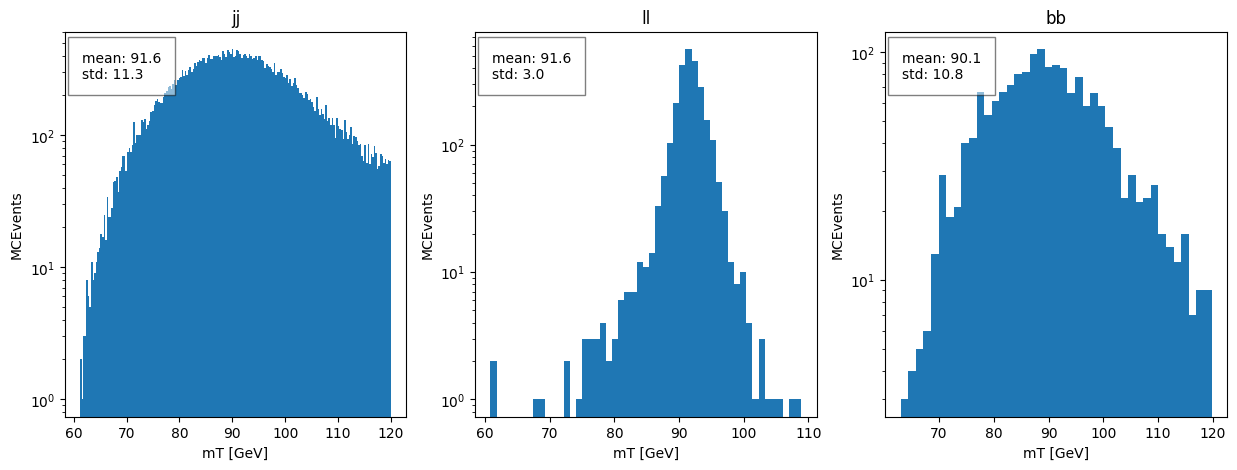

In [8]:
import matplotlib.pyplot as plt
import numpy as np
# create len(mT_results) subplots and unpack the axes array immediately
fig, axs = plt.subplots(1, len(mT_results), figsize=(15, 5))
for ax, case in zip(axs, mT_results):
    # Fill the histogram
    ax.hist(mT_results[case], bins=int(np.sqrt(len(mT_results[case]))))
    # add a frame with main stats
    ax.text(
        0.05, 0.95,
        f'mean: {np.mean(mT_results[case]):.1f}\nstd: {np.std(mT_results[case]):.1f}',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}
    )
    ax.set_title(case)
    ax.set_xlabel('m [GeV]')
    ax.set_ylabel('MCEvents')
    # set log scale
    ax.set_yscale('log')
plt.show()


In [6]:
import pandas as pd
efficiency_df = pd.DataFrame(
    index=['efficiency', 'uncertainty', 'relative uncertainty (%)']
    )
for case in mT_results:
    # get the efficiency
    efficiency = len(mT_results[case])/n_events
    eff_err = np.sqrt(efficiency*(1-efficiency)/n_events)
    efficiency_df[case] = [efficiency, eff_err, eff_err*100/efficiency]
efficiency_df

,jj,ll,bb
efficiency,0.099832,0.006496,0.004346
uncertainty,0.000474,0.000127,0.000104
relative uncertainty (%),0.474445,1.954030,2.391414


Como ejercicio tal vez sea bueno pedir cortes adicionales y que evalúen la eficiencia relativa y absoluta de cada uno de ellos.